# LSTM Model with Additional Features for TotalConsumption Prediction


## Ziel:
Das Notebook implementiert ein LSTM-Modell, das nicht nur **TotalConsumption**, sondern auch zusätzliche Features wie **Temperature**, **Humidity**, **Wind Speed**, **General Diffuse Flows** und **Diffuse Flows** berücksichtigt.

### Zusätzliche Features:
- **Temperature**: Umgebungstemperatur
- **Humidity**: Relative Luftfeuchtigkeit
- **Wind Speed**: Windgeschwindigkeit
- **General Diffuse Flows**: Diffuse Strahlung allgemein
- **Diffuse Flows**: Diffuse Strahlung spezifisch
    

In [1]:
%pip install pandas scikit-learn matplotlib seaborn plotly nbformat tensorflow==2.10.0 keras keras_tuner protobuf

Note: you may need to restart the kernel to use updated packages.


In [2]:

# Bibliotheken importieren
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


## 1. Datenvorbereitung

In [3]:

# Daten laden
file_path = 'consumption-data/consumption.csv'
data = pd.read_csv(file_path)

# TotalConsumption berechnen
data['TotalConsumption'] = data['Zone 1 Power Consumption'] + data['Zone 2  Power Consumption'] + data['Zone 3  Power Consumption']

# Datumsformat und Index setzen
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

# Zusätzliche Features einbeziehen
time_series = data[['TotalConsumption', 'Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows']]

# Skalierung vorbereiten
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Skalierung auf Zielwert und Features anwenden
scaled_target = target_scaler.fit_transform(time_series[['TotalConsumption']])
scaled_features = scaler.fit_transform(time_series.iloc[:, 1:])

# Kombinieren der skalierten Daten
combined_scaled = np.hstack([scaled_target, scaled_features])


In [4]:

# Funktion zur Sequenzgenerierung
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length, 1:])  # Features
        y.append(data[i + sequence_length, 0])    # Zielwert (TotalConsumption)
    return np.array(x), np.array(y)

# Sequenzen erstellen
sequence_length = 64
x, y = create_sequences(combined_scaled, sequence_length)

# Trainings- und Testdaten aufteilen
train_size = int(len(x) * 0.8)  # 80% der Daten für Training
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]


## 2. LSTM-Modell erstellen und trainieren

In [5]:
# Modell definieren
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, x_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Modell kompilieren
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Modellübersicht
model.summary()

# Training des Modells
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64, 64)            17920     
                                                                 
 dropout (Dropout)           (None, 64, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 53,057
Trainable params: 53,057
Non-traina

## 3. Modellvorhersagen und Evaluierung

In [6]:

# Vorhersagen
full_predictions_scaled = model.predict(x)
full_predictions = target_scaler.inverse_transform(full_predictions_scaled)

# Tatsächliche Werte zurückskalieren
actual_values = target_scaler.inverse_transform(y.reshape(-1, 1))

# Testdaten-Vorhersagen zurückskalieren
test_predictions_scaled = model.predict(x_test)
test_predictions = target_scaler.inverse_transform(test_predictions_scaled)
test_actual_values = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Leistungsmetriken
mae = mean_absolute_error(test_actual_values, test_predictions)
rmse = mean_squared_error(test_actual_values, test_predictions, squared=False)
r2 = r2_score(test_actual_values, test_predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"R-Squared (R2): {r2}")


328/328 [==============================] - 3s 8ms/step
Mean Absolute Error (MAE): 3784.08576234216
Root Mean Square Error (RMSE): 5320.136445724924
R-Squared (R2): 0.8579319959859503


c:\Users\TimSteiner\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 4. Visualisierungen

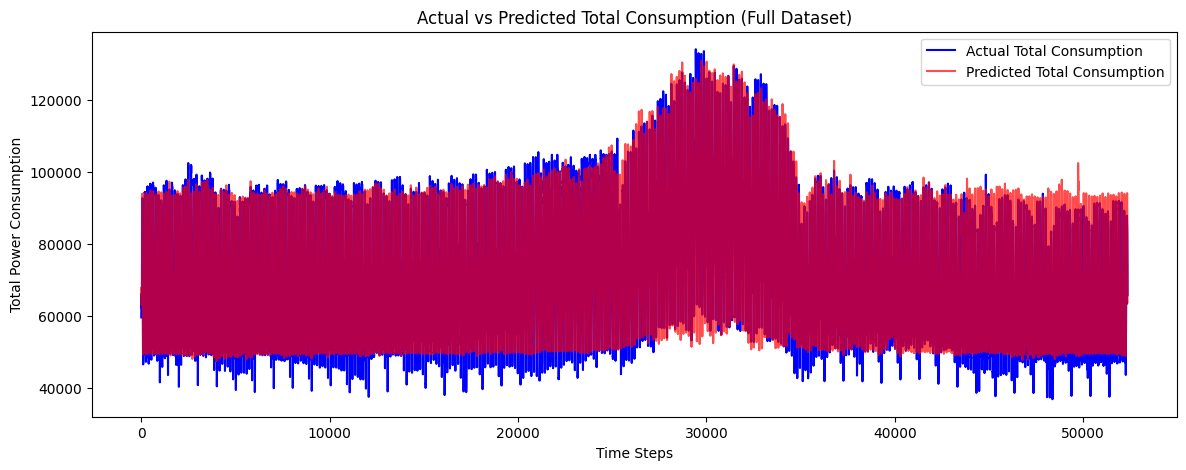

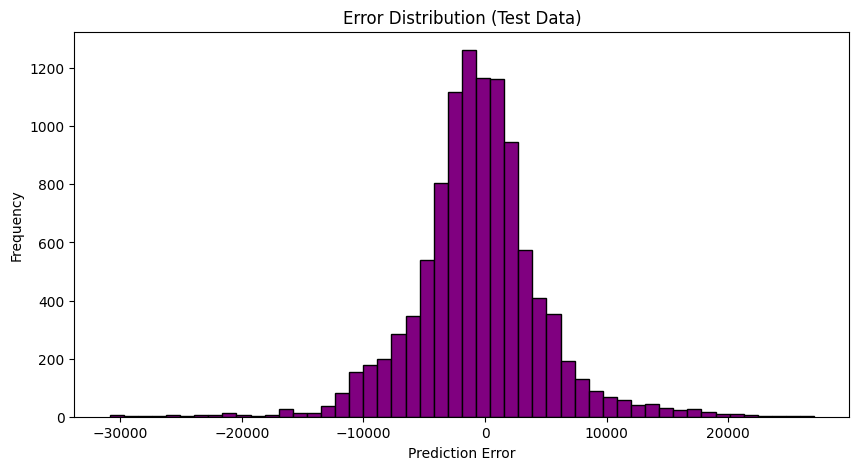

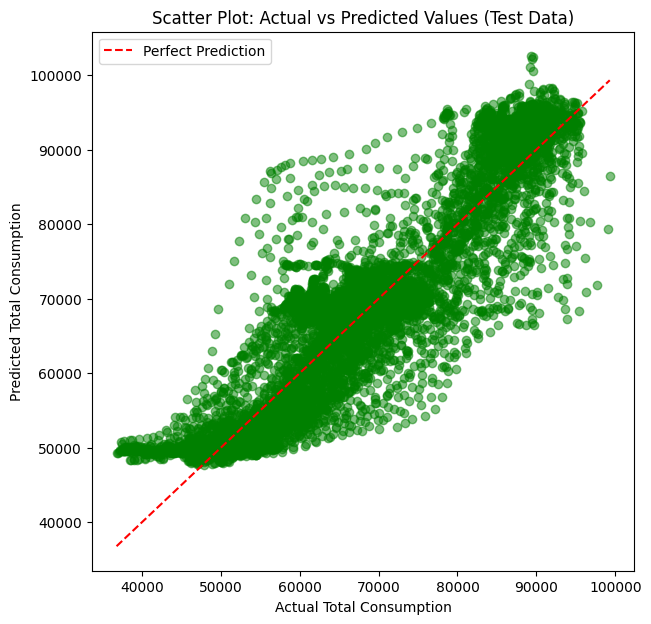

In [7]:

# Zeitserienvergleich
plt.figure(figsize=(14, 5))
plt.plot(actual_values, label='Actual Total Consumption', color='blue')
plt.plot(full_predictions, label='Predicted Total Consumption', color='red', alpha=0.7)
plt.title('Actual vs Predicted Total Consumption (Full Dataset)')
plt.xlabel('Time Steps')
plt.ylabel('Total Power Consumption')
plt.legend()
plt.show()

# Fehlerverteilung
errors = test_actual_values - test_predictions
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, color='purple', edgecolor='black')
plt.title('Error Distribution (Test Data)')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

# Streudiagramm
plt.figure(figsize=(7, 7))
plt.scatter(test_actual_values, test_predictions, alpha=0.5, color='green')
plt.plot([min(test_actual_values), max(test_actual_values)],
         [min(test_actual_values), max(test_actual_values)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.title('Scatter Plot: Actual vs Predicted Values (Test Data)')
plt.xlabel('Actual Total Consumption')
plt.ylabel('Predicted Total Consumption')
plt.legend()
plt.show()
